In [3]:
import re
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup

# Silence warnings
def warn(*args, **kwargs):
    pass

import warnings
warnings.warn = warn
warnings.filterwarnings("ignore")


## SAVING WEBSOURCES

In [61]:
SOURCES = {
    "DDHQ": "https://polls.decisiondeskhq.com/averages/presidential-approval/donald-trump-150479/national/lv-rv-adults",
    "FiftyPlusOne": "https://fiftyplusone.news/polls/approval/president",
    "SilverBulletin": "https://www.natesilver.net/p/trump-approval-ratings-nate-silver-bulletin"
}

HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; JuaniScraper/1.0; +https://example.com/bot)",
    "Accept-Language": "en-US,en;q=0.9",
}

def fetch_html(url: str) -> str:
    r = requests.get(url, headers=HEADERS, timeout=30)
    #Check success status
    r.raise_for_status()
    return r.text

# Smoke test: see status code of each source
for name, url in SOURCES.items():
    try:
        r = requests.get(url, headers=HEADERS, timeout=30)
        print(name, r.status_code)
    except Exception as e:
        print(name, "ERROR", e)

DDHQ 200
FiftyPlusOne 200
SilverBulletin 200


## DDHQ

In [89]:
def parse_ddhq(html: str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    text = soup.get_text(" ", strip=True)

    dis_m = re.search(r"\bDisapprove\b\s+(\d+(?:\.\d+)?)%", text, flags=re.IGNORECASE)
    app_m = re.search(r"\bApprove\b\s+(\d+(?:\.\d+)?)%", text, flags=re.IGNORECASE)

    if not dis_m or not app_m:
        raise ValueError("No pude encontrar Approve/Disapprove en DDHQ.")

    Disapprove = float(dis_m.group(1))
    Approve = float(app_m.group(1))

    return {
        "Source": "DDHQ",
        "Approve": Approve,
        "Disapprove": Disapprove,
        "Net Approval (+-)": Approve - Disapprove,
    }


## FiftyPlusOne

In [88]:
def parse_fiftyplusone(html: str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    text = soup.get_text(" ", strip=True)

    dis_m = re.search(r"\bDisapprove\b\s+(\d+(?:\.\d+)?)%", text, flags=re.IGNORECASE)
    app_m = re.search(r"\bApprove\b\s+(\d+(?:\.\d+)?)%", text, flags=re.IGNORECASE)

    if not dis_m or not app_m:
        raise ValueError("No pude encontrar Approve/Disapprove en FiftyPlusOne.")

    Disapprove = float(dis_m.group(1))
    Approve = float(app_m.group(1))

    return {
        "Source": "FiftyPlusOne",
        "Approve": Approve,
        "Disapprove": Disapprove,
        "Net Approval (+-)": Approve - Disapprove,
    }


## Silver Bulletin

In [87]:
def parse_silverbull(html: str) -> dict:
    soup = BeautifulSoup(html, "lxml")
    text = soup.get_text(" ", strip=True)

    # Ejemplos en el texto público:
    # "Updated February 17, 2026"
    # "net approval rating ... -15.0"
    # "approve ... 40.5 percent"
    upd_m = re.search(r"\bUpdated\s+([A-Za-z]+\s+\d{1,2},\s+\d{4})\b", text)
    net_m = re.search(r"\bnet approval rating\b.*?([-\u2212]?\d+(?:\.\d+)?)", text, flags=re.IGNORECASE)
    app_m = re.search(r"\bapprove\b.*?([-\u2212]?\d+(?:\.\d+)?)\s*percent\b", text, flags=re.IGNORECASE)

    if not net_m or not app_m:
        raise ValueError("No pude encontrar net approval y approve% en el texto público de Silver Bulletin (posible paywall/layout).")

    net = float(net_m.group(1).replace("−", "-"))
    approve = float(app_m.group(1).replace("−", "-"))

    # Net = Approve - Disapprove  =>  Disapprove = Approve - Net
    disapprove = approve - net

    return {
        "Source": "SilverBulletin",
        "Approve": approve,
        "Disapprove": disapprove,
        "Net Approval (+-)": net,
        # Nota: si quieres guardar el 'Updated ...' luego lo metemos como columna extra,
        # pero por ahora lo dejamos fuera (siguiendo tu decisión de quitar "as_of").
    }


## Data Frame of Daily Snapshot

In [86]:
def get_latest_snapshot() -> pd.DataFrame:
    rows = []

    # DDHQ
    ddhq_html = fetch_html(SOURCES["DDHQ"])
    rows.append(parse_ddhq(ddhq_html))

    # FiftyPlusOne
    fpo_html = fetch_html(SOURCES["FiftyPlusOne"])
    rows.append(parse_fiftyplusone(fpo_html))

    # Silver Bulletin (Nate Silver)
    sb_ok = False
    try:
        sb_html = fetch_html(SOURCES["SilverBulletin"])
        row_sb = parse_silverbull(sb_html)
        rows.append(row_sb)
        sb_ok = True
    except Exception as e:
        print("SilverBulletin SKIP ->", repr(e))

    df = pd.DataFrame(rows)

    # Debug rápido
    print("Rows loaded:", df["Source"].tolist())
    if not sb_ok:
        print("SilverBulletin no entró al snapshot (parse falló o paywall/layout).")

    # Global mean
    global_row = {
        "Source": "GLOBAL_MEAN",
        "Approve": df["Approve"].mean(),
        "Disapprove": df["Disapprove"].mean(),
        "Net Approval (+-)": df["Net Approval (+-)"].mean(),
    }

    df_out = pd.concat([df, pd.DataFrame([global_row])], ignore_index=True)

    df_out[["Approve", "Disapprove", "Net Approval (+-)"]] = (
        df_out[["Approve", "Disapprove", "Net Approval (+-)"]].round(2)
    )

    return df_out


df_snapshot = get_latest_snapshot()
df_snapshot


Rows loaded: ['DDHQ', 'FiftyPlusOne', 'SilverBulletin']


,Source,Approve,Disapprove,Net Approval (+-)
0,DDHQ,41.40,55.80,-14.4
1,FiftyPlusOne,38.80,57.10,-18.3
2,SilverBulletin,40.50,55.50,-15.0
3,GLOBAL_MEAN,40.23,56.13,-15.9


## Graphic of Daily Snapshot

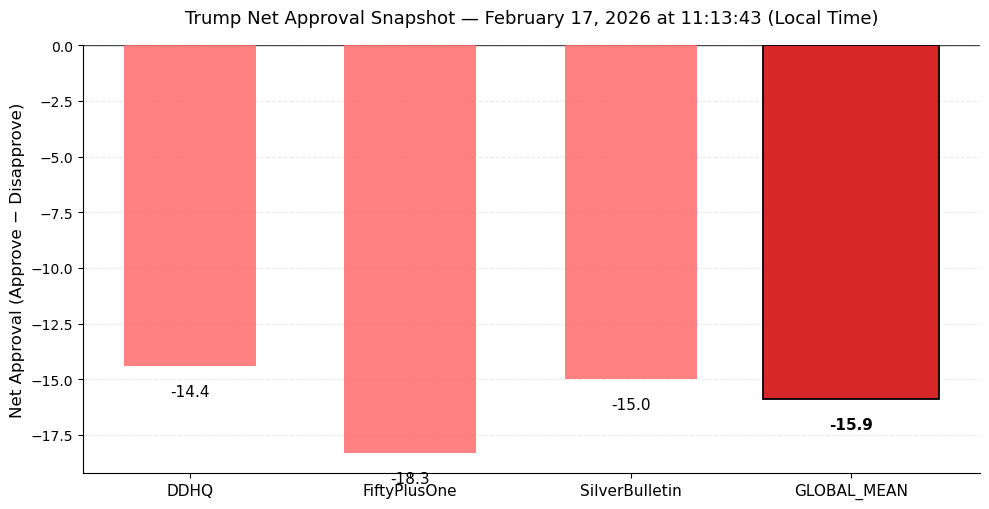

In [90]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Timestamp bonito
# ---------------------------
snapshot_dt = datetime.now()
snapshot_label = snapshot_dt.strftime("%B %d, %Y at %H:%M:%S")
title = f"Trump Net Approval Snapshot — {snapshot_label} (Local Time)"

# ---------------------------
# Data
# ---------------------------
df_plot = df_snapshot.copy()

# Asegurar que GLOBAL quede al final
is_global = df_plot["Source"].eq("GLOBAL_MEAN")
df_plot = pd.concat([df_plot[~is_global], df_plot[is_global]], ignore_index=True)

sources = df_plot["Source"].tolist()
nets = df_plot["Net Approval (+-)"].astype(float).to_numpy()

x = np.arange(len(sources))

# ---------------------------
# Figure
# ---------------------------
fig, ax = plt.subplots(figsize=(10, 5.2))

# Paleta más elegante
soft_red = "#ff6b6b"
deep_red = "#d62828"
neutral_gray = "#6c757d"

colors = []
for src, val in zip(sources, nets):
    if src == "GLOBAL_MEAN":
        colors.append(deep_red if val < 0 else "#2a9d8f")
    else:
        colors.append(soft_red if val < 0 else "#74c69d")

# ---------------------------
# Bars
# ---------------------------
for i, (xi, val) in enumerate(zip(x, nets)):
    if sources[i] == "GLOBAL_MEAN":
        ax.bar(
            xi,
            val,
            width=0.8,
            color=colors[i],
            edgecolor="black",
            linewidth=1.3,
            zorder=3
        )
    else:
        ax.bar(
            xi,
            val,
            width=0.6,
            color=colors[i],
            alpha=0.85,
            zorder=3
        )

# Línea cero más fina
ax.axhline(0, linewidth=1, color="black", alpha=0.7)

# ---------------------------
# Labels
# ---------------------------
for xi, val, src in zip(x, nets, sources):
    offset = 0.8
    ax.text(
        xi,
        val + (offset if val >= 0 else -offset),
        f"{val:.1f}",
        ha="center",
        va="bottom" if val >= 0 else "top",
        fontsize=11,
        fontweight="bold" if src == "GLOBAL_MEAN" else "normal",
        color="black"
    )

# ---------------------------
# Styling
# ---------------------------
ax.set_xticks(x)
ax.set_xticklabels(sources, fontsize=11)
ax.set_ylabel("Net Approval (Approve − Disapprove)", fontsize=12)
ax.set_title(title, fontsize=13, pad=16)

ax.grid(axis="y", linestyle="--", alpha=0.25)
ax.set_axisbelow(True)

# Limpiar bordes superiores
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()


## Save Historic to CSV

In [99]:
from datetime import datetime
import os
import pandas as pd

path = "trump_approval_log.csv"

# =========================
# SNAPSHOT ACTUAL
# =========================
expected_cols = ["Source", "Approve", "Disapprove", "Net Approval (+-)"]

df_log = df_snapshot.copy()

# Asegurar columnas base
df_log = df_log[expected_cols].copy()

# Timestamp UTC consistente (sin microsegundos)
now_utc = pd.Timestamp.utcnow().floor("s")
df_log["scrape_timestamp_utc"] = now_utc.isoformat()
df_log["scrape_date_utc"] = now_utc.date().isoformat()

# =========================
# CARGA + NORMALIZACIÓN HISTÓRICO
# =========================
def normalize_history(df: pd.DataFrame) -> pd.DataFrame:
    # 1) limpiar nombres de columnas
    df = df.copy()
    df.columns = df.columns.astype(str).str.strip()

    # 2) mapear nombres viejos -> nuevos
    rename_map = {
        "source": "Source",
        "approve": "Approve",
        "disapprove": "Disapprove",
        "net": "Net Approval (+-)",
    }
    df = df.rename(columns=rename_map)

    # 3) Si al renombrar quedaron columnas duplicadas, nos quedamos con la última
    df = df.loc[:, ~df.columns.duplicated(keep="last")]

    # 4) asegurar que existan columnas mínimas
    for col in expected_cols + ["scrape_timestamp_utc", "scrape_date_utc"]:
        if col not in df.columns:
            df[col] = pd.NA

    # 5) limpiar Source (evitar NaN y "nan")
    df["Source"] = df["Source"].astype("string").str.strip()
    df = df[df["Source"].notna()]
    df = df[df["Source"].str.lower() != "nan"]
    df = df[df["Source"] != ""]

    # 6) normalizar fechas/timestamps
    df["scrape_timestamp_utc"] = pd.to_datetime(df["scrape_timestamp_utc"], errors="coerce", utc=True).dt.floor("s")
    df["scrape_date_utc"] = pd.to_datetime(df["scrape_date_utc"], errors="coerce", utc=True).dt.date.astype("string")

    # 7) métricas a numérico
    for col in ["Approve", "Disapprove", "Net Approval (+-)"]:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # 8) quitar filas rotas (sin fecha)
    df = df.dropna(subset=["scrape_date_utc"])

    return df

if os.path.exists(path):
    df_existing = pd.read_csv(path)
    df_existing = normalize_history(df_existing)
else:
    df_existing = pd.DataFrame(columns=expected_cols + ["scrape_timestamp_utc", "scrape_date_utc"])

# Normalizar df_log para que tenga mismo tipo/formato que histórico
df_log = normalize_history(df_log)

# =========================
# MERGE + DEDUPE (1 por día y fuente)
# =========================
df_combined = pd.concat([df_existing, df_log], ignore_index=True, sort=False)

df_combined = df_combined.sort_values(
    ["scrape_date_utc", "Source", "scrape_timestamp_utc"]
)

df_combined = df_combined.drop_duplicates(
    subset=["scrape_date_utc", "Source"],
    keep="last"
)

df_combined = df_combined.sort_values(
    ["scrape_date_utc", "Source"]
).reset_index(drop=True)

# Guardar
df_combined.to_csv(path, index=False)

print(f"Histórico actualizado correctamente → {path}")
print(f"Total registros históricos: {len(df_combined)}")
print("Registros por fuente (conteo histórico):")
print(df_combined["Source"].value_counts().sort_index())


Histórico actualizado correctamente → trump_approval_log.csv
Total registros históricos: 4
Registros por fuente (conteo histórico):
Source
DDHQ              1
FiftyPlusOne      1
GLOBAL_MEAN       1
SilverBulletin    1
Name: count, dtype: Int64


## Graph Historic

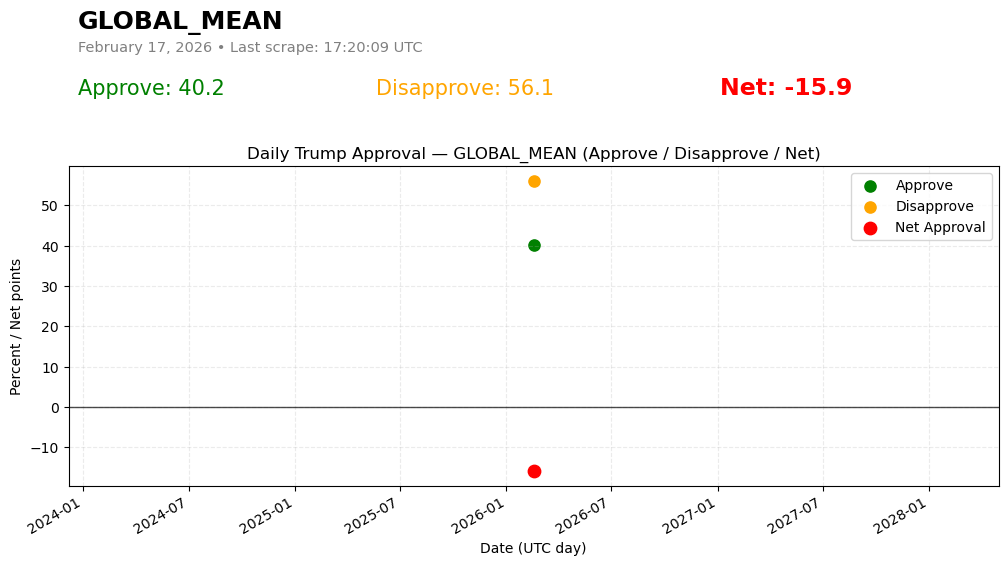

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# LOAD HISTORICAL DATA
# =========================

path = "trump_approval_log.csv"
df_hist = pd.read_csv(path)

# Normalizar fechas
df_hist["scrape_date_utc"] = pd.to_datetime(df_hist["scrape_date_utc"], errors="coerce")
df_hist["scrape_timestamp_utc"] = pd.to_datetime(df_hist["scrape_timestamp_utc"], errors="coerce")

# Limpiar filas rotas (por si algún día quedó algo mal)
df_hist = df_hist.dropna(subset=["scrape_date_utc", "scrape_timestamp_utc", "Source"])

# Mantener solo última corrida por día y fuente
df_hist = df_hist.sort_values(["scrape_date_utc", "Source", "scrape_timestamp_utc"])
df_hist = df_hist.drop_duplicates(subset=["scrape_date_utc", "Source"], keep="last")

# =========================
# FILTRAR GLOBAL_MEAN
# =========================

df_g = (
    df_hist[df_hist["Source"] == "GLOBAL_MEAN"]
    .copy()
    .sort_values("scrape_date_utc")
)

# Si solo hay 1 día, igual funciona
x = df_g["scrape_date_utc"]
approve = df_g["Approve"].astype(float)
disapprove = df_g["Disapprove"].astype(float)
net = df_g["Net Approval (+-)"].astype(float)

# =========================
# CREATE FIGURE WITH SPACE
# =========================

fig = plt.figure(figsize=(12, 7))

gs = fig.add_gridspec(
    nrows=2,
    ncols=1,
    height_ratios=[1.3, 4],
    hspace=0.25
)

ax_top = fig.add_subplot(gs[0])
ax = fig.add_subplot(gs[1])

# =========================
# TOP PANEL (DASHBOARD)
# =========================

ax_top.axis("off")

last = df_g.iloc[-1]
last_day = last["scrape_date_utc"].strftime("%B %d, %Y")
last_time = last["scrape_timestamp_utc"].strftime("%H:%M:%S UTC")

last_approve = float(last["Approve"])
last_disapprove = float(last["Disapprove"])
last_net = float(last["Net Approval (+-)"])

net_color = "green" if last_net > 0 else "red" if last_net < 0 else "gray"

# Header
ax_top.text(0.01, 0.82, "GLOBAL_MEAN", fontsize=18, fontweight="bold", ha="left")
ax_top.text(0.01, 0.60, f"{last_day} • Last scrape: {last_time}", fontsize=10.5, color="gray", ha="left")

# Metrics row
ax_top.text(0.01, 0.18, f"Approve: {last_approve:.1f}", fontsize=15, color="green", ha="left")
ax_top.text(0.33, 0.18, f"Disapprove: {last_disapprove:.1f}", fontsize=15, color="orange", ha="left")
ax_top.text(0.70, 0.18, f"Net: {last_net:.1f}", fontsize=17, fontweight="bold", color=net_color, ha="left")

# =========================
# SCATTER PLOT
# =========================

ax.scatter(x, approve, label="Approve", c="green", s=65)
ax.scatter(x, disapprove, label="Disapprove", c="orange", s=65)

net_colors = np.where(net > 0, "green", np.where(net < 0, "red", "gray"))
ax.scatter(x, net, label="Net Approval", c=net_colors, s=80)

ax.axhline(0, linewidth=1, color="black", alpha=0.7)

ax.set_title("Daily Trump Approval — GLOBAL_MEAN (Approve / Disapprove / Net)", fontsize=12)
ax.set_xlabel("Date (UTC day)")
ax.set_ylabel("Percent / Net points")

ax.grid(alpha=0.25, linestyle="--")
ax.legend(loc="upper right")

# Para que se vean bien las fechas cuando haya muchos días
fig.autofmt_xdate()

plt.tight_layout()
plt.show()

